In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.set_option('display.max_columns', 500)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy.random
import statsmodels.nonparametric
import scipy.stats

In [66]:
bets = pd.read_csv('../../../data/datasets_for_analysis/final_datasets/odds_w_outcomes.csv')
bets['Card_Date'] = pd.to_datetime(bets['Card_Date'] )
bets['year'] = bets['Card_Date'].dt.year

In [67]:
# convert decimal odds to probabilities using the balanced book method
betting_sites= ['5Dimes','BetDSI','BookMaker','SportBet','Bet365','Bovada', 
                'Sportsbook','William_H','Pinnacle','SportsInt','BetOnline','Intertops']

for col in betting_sites:
    bets[col+"_prob"] =  ((bets[col]**-1) - bets[col+"_vig"])/(1-bets[col+"_vig"]) 

bets["avg_prob"] = bets[[col+"_prob" for col in betting_sites]].apply("mean", axis = 1)

In [68]:
# look at 2013 - 2020 30% - 50% probability range
bets_recent = bets[(bets.year >= 2013)& (bets.avg_prob >= .3) & (bets.avg_prob <= .5)].copy()
bets_recent.Card_Cleaned.value_counts()

Prelim        1274
Main Event     898
Name: Card_Cleaned, dtype: int64

In [69]:
bets_recent['bet_won_main'] = np.where(bets_recent.Card_Cleaned == 'Prelim', np.nan, bets_recent.bet_won)
bets_recent['bet_won_prelim'] = np.where(bets_recent.Card_Cleaned == 'Prelim',  bets_recent.bet_won, np.nan)
bins = np.arange(.3,.5, .025)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets_recent.avg_prob, divided)
grouped = bets_recent.groupby(consensus_group)['bet_won_main', 'bet_won_prelim', 'avg_prob'].agg(
    avg_prob = ('avg_prob', 'mean'),
   bet_won_main=('bet_won_main', 'mean'),
   num_bet_won_main =  ('bet_won_main', 'sum'), 
    bet_won_prelim=('bet_won_prelim', 'mean'),
   num_bet_won_prelim =  ('bet_won_prelim', 'sum'),
      n_main = ('bet_won_main', 'count'),
      n_prelim = ('bet_won_prelim', 'count'),
      n = ('avg_prob','size'))
grouped['diff_main'] = grouped['bet_won_main'] - grouped['avg_prob']
grouped['diff_prelim'] = grouped['bet_won_prelim'] - grouped['avg_prob']
grouped['p_val_main'] = grouped.apply(lambda x: statsmodels.stats.proportion.binom_test(x.num_bet_won_main, x.n_main, x.avg_prob), axis = 1)
grouped['p_val_prelim'] = grouped.apply(lambda x: statsmodels.stats.proportion.binom_test(x.num_bet_won_prelim, x.n_prelim, x.avg_prob), axis = 1)

del grouped['num_bet_won_main'], grouped['num_bet_won_prelim']
display(grouped[['diff_main', 'p_val_main', 'n_main', 'diff_prelim', 'p_val_prelim', 'n_prelim', 'n']])

,diff_main,p_val_main,n_main,diff_prelim,p_val_prelim,n_prelim,n
avg_prob,,,,,,,
"(0.3, 0.325]",0.047657,0.331401,100,-0.004650,1.000000,130,230
"(0.325, 0.35000000000000003]",0.041720,0.342511,124,-0.040760,0.334184,145,269
"(0.35000000000000003, 0.37500000000000006]",0.047315,0.349485,100,0.070649,0.074827,150,250
"(0.37500000000000006, 0.4000000000000001]",0.095137,0.020568,143,0.034241,0.365212,185,328
"(0.4000000000000001, 0.4250000000000001]",0.088351,0.041969,132,0.031594,0.411346,185,317
"(0.4250000000000001, 0.4500000000000001]",0.126879,0.007091,119,-0.044842,0.266473,161,280
"(0.4500000000000001, 0.47500000000000014]",0.006921,0.920309,100,-0.002040,1.000000,154,254


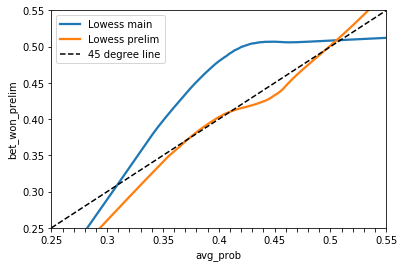

In [70]:
bets_recent = bets[(bets.year >= 2013)& (bets.avg_prob >= .25) & (bets.avg_prob <= .55)].copy()
bets_recent['bet_won_main'] = np.where(bets_recent.Card_Cleaned == 'Prelim', np.nan, bets_recent.bet_won)
bets_recent['bet_won_prelim'] = np.where(bets_recent.Card_Cleaned == 'Prelim',  bets_recent.bet_won, np.nan)

fig, ax = plt.subplots()
sns.regplot('avg_prob', 'bet_won_main', data = bets_recent, 
            scatter = False, lowess = True, ax = ax, label = 'Lowess main')
sns.regplot('avg_prob', 'bet_won_prelim', data = bets_recent, 
            scatter = False, lowess = True, ax = ax, label = 'Lowess prelim')
x = np.linspace(.25, .55, 100)
ax.plot(x, x, 'k--',label = '45 degree line')
ax.set_xticks(np.arange(.25,.56,.01))
ax.set_ylim(.25,.55)
ax.set_xlim(.25,.55)
ax.set_xticklabels([round(x,2) if i%5 == 0 else '' for i, x in enumerate(np.arange(.25,.56,.01))])
ax.legend(loc='best')

It looks like most of the overperformance is coming from fighters fighting on the main card. This might be a case of their opponents being overhyped. 

Prelim        641
Main Event    511
Name: Card_Cleaned, dtype: int64


,diff_main,p_val_main,n_main,diff_prelim,p_val_prelim,n_prelim,n
avg_prob,,,,,,,
"(0.25, 0.275]",-0.012647,1.000000,56,-0.051109,0.528196,52,108
"(0.275, 0.30000000000000004]",0.032075,0.640005,50,0.071450,0.214968,64,114
"(0.30000000000000004, 0.32500000000000007]",-0.027022,0.773523,56,0.073228,0.253286,57,113
"(0.32500000000000007, 0.3500000000000001]",0.065098,0.284725,62,-0.058128,0.329553,75,137
"(0.3500000000000001, 0.3750000000000001]",-0.028357,0.771284,51,0.021643,0.788383,60,111
"(0.3750000000000001, 0.40000000000000013]",0.028391,0.734795,36,-0.054943,0.428280,60,96
"(0.40000000000000013, 0.42500000000000016]",-0.012670,0.886907,50,-0.072670,0.318192,50,100
"(0.42500000000000016, 0.4500000000000002]",-0.042728,0.706482,28,0.174171,0.027436,41,69
"(0.4500000000000002, 0.4750000000000002]",-0.055344,0.700332,27,0.006636,1.000000,49,76


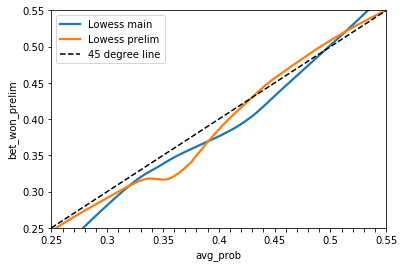

In [71]:
# look at 2008 - 2012 30% - 50% probability range broken out by main vs prelim
bets_recent = bets[(bets.year < 2013)& (bets.avg_prob >= .25) & (bets.avg_prob <= .55)].copy()
print(bets_recent.Card_Cleaned.value_counts())
bets_recent['bet_won_main'] = np.where(bets_recent.Card_Cleaned == 'Prelim', np.nan, bets_recent.bet_won)
bets_recent['bet_won_prelim'] = np.where(bets_recent.Card_Cleaned == 'Prelim',  bets_recent.bet_won, np.nan)
bins = np.arange(.25,.55, .025)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets_recent.avg_prob, divided)

grouped = bets_recent.groupby(consensus_group)['bet_won_main', 'bet_won_prelim', 'avg_prob'].agg(
avg_prob = ('avg_prob', 'mean'),
bet_won_main=('bet_won_main', 'mean'),
num_bet_won_main =  ('bet_won_main', 'sum'), 
bet_won_prelim=('bet_won_prelim', 'mean'),
num_bet_won_prelim =  ('bet_won_prelim', 'sum'),
n_main = ('bet_won_main', 'count'),
n_prelim = ('bet_won_prelim', 'count'),
n = ('avg_prob','size'))

grouped['diff_main'] = grouped['bet_won_main'] - grouped['avg_prob']
grouped['diff_prelim'] = grouped['bet_won_prelim'] - grouped['avg_prob']
grouped['p_val_main'] = grouped.apply(lambda x: statsmodels.stats.proportion.binom_test(x.num_bet_won_main, x.n_main, x.avg_prob), axis = 1)
grouped['p_val_prelim'] = grouped.apply(lambda x: statsmodels.stats.proportion.binom_test(x.num_bet_won_prelim, x.n_prelim, x.avg_prob), axis = 1)

del grouped['num_bet_won_main'], grouped['num_bet_won_prelim']
display(grouped[['diff_main', 'p_val_main', 'n_main', 'diff_prelim', 'p_val_prelim', 'n_prelim', 'n']])

fig, ax = plt.subplots()
sns.regplot('avg_prob', 'bet_won_main', data = bets_recent, 
            scatter = False, lowess = True, ax = ax, label = 'Lowess main')
sns.regplot('avg_prob', 'bet_won_prelim', data = bets_recent, 
            scatter = False, lowess = True, ax = ax, label = 'Lowess prelim')
x = np.linspace(.25, .55, 100)
ax.plot(x, x, 'k--',label = '45 degree line')
ax.set_xticks(np.arange(.25,.56,.01))
ax.set_ylim(.25,.55)
ax.set_xlim(.25,.55)
ax.set_xticklabels([round(x,2) if i%5 == 0 else '' for i, x in enumerate(np.arange(.25,.56,.01))])
ax.legend(loc='best')

In [72]:
def get_return_based_on_prob_range(df, prob_col, prob_min, prob_max):
    num_fights = df.groupby('year').agg(total_fights = (prob_col, lambda x: x.size)).reset_index()
    df = df[(df[prob_col] >= prob_min) & (df[prob_col] <= prob_max)].copy()
    df['breakeven_prob'] = 1/df['best_odds']
    out = df.groupby('year').agg(
        num_bets = (prob_col, "size"),
       avg_odds = ('best_odds', "mean"),
       avg_breakeven_prob = ('breakeven_prob', "mean"),
       pct_won = ('bet_won', "mean"),
       avg_estimated_vig = ('best_odds_vig', "mean"),
       avg_return = ('return', "mean"),
       std_return = ('return', 'std')
      ).reset_index()
    out = pd.merge(num_fights, out, on = 'year')
    out['% fights bet'] = out['num_bets']/out['total_fights']
    return out[['year', 'total_fights', 'num_bets', '% fights bet', 'avg_odds', 
                'avg_breakeven_prob', 'pct_won', 'avg_estimated_vig', 'avg_return', 'std_return']]
print('bets with avg vig adjusted probability in the .375 to .45 range')
bets['best_odds'] = bets[betting_sites].apply("max", axis = 1)
bets['return'] = np.where(bets['bet_won'] == 1, bets['best_odds'] -1, -1)
bets["best_odds_site"] = bets[[col for col in betting_sites]].apply(pd.Series.idxmax, axis = 1)
bets['breakeven_prob'] = 1/bets['best_odds']
bets["best_odds_vig"] = bets['breakeven_prob'] - bets.lookup(bets.index, bets["best_odds_site"].apply(lambda x: x+"_prob"))
bets_recent_main = bets[(bets.Card_Cleaned == 'Main Event')]
display(get_return_based_on_prob_range(bets_recent_main, 'avg_prob', .375, .45))

bets with avg vig adjusted probability in the .375 to .45 range


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,198.0,24,0.121212,2.403333,0.417660,0.333333,0.022938,-0.206667,1.149074
1,2009,200.0,19,0.095000,2.428421,0.412643,0.368421,0.017385,-0.115789,1.191439
2,2010,230.0,23,0.100000,2.398261,0.417952,0.391304,0.018003,-0.052174,1.209835
3,2011,250.0,25,0.100000,2.380000,0.421302,0.560000,0.015316,0.330800,1.207014
4,2012,308.0,22,0.071429,2.399545,0.417440,0.363636,0.020667,-0.131364,1.178301
5,2013,340.0,31,0.091176,2.422581,0.413913,0.483871,0.018604,0.164516,1.225596
6,2014,400.0,43,0.107500,2.415814,0.414808,0.488372,0.013957,0.174186,1.218059
7,2015,424.0,49,0.115566,2.389796,0.419663,0.571429,0.016571,0.364898,1.198576
8,2016,416.0,57,0.137019,2.400175,0.417793,0.526316,0.016480,0.258421,1.208009
9,2017,402.0,53,0.131841,2.383396,0.420611,0.452830,0.018224,0.086981,1.208444
